# Computer Vision for Fire Spread

##### Image:

### Cell 1: Global Configuration & Imports

In [24]:
# Cell 1: Global configuration & imports

# Global configuration
# IMAGE_FOLDER = r"C:\Users\samih\Documents\ShareX\Screenshots\For VS Vision\34 x 34\QUAD, 1 Log, 2 Bush, 3 Hay, 4 Leaves\v1"
IMAGE_FOLDER = r"C:\Users\samih\Documents\ShareX\Screenshots\For VS Vision\34 x 34\Green Wool = Leaves\v10"
images_folder = IMAGE_FOLDER

GRID_SIZE = 34
TIME_STEP = 1           # Time step between images in seconds
DEFAULT_IMAGE_STEP = 1 # Process every nth image (change as needed)

import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from IPython.display import HTML, display


### Cell 2: RAW Image Loading and Animation

In [25]:
# def load_raw_images(images_folder, image_step=DEFAULT_IMAGE_STEP):
#     """
#     Load all RAW image files (PNG or JPG) from the folder sorted by modification time,
#     then subsample based on image_step.
#     """
#     image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
#     if not image_paths:
#         image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
#     image_paths = image_paths[::image_step]  # Subsample

#     images = []
#     for path in image_paths:
#         img = cv2.imread(path)
#         if img is None:
#             print(f"Warning: Could not load image {path}")
#         else:
#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             images.append(img_rgb)
#     if not images:
#         raise ValueError("No images were loaded. Check your folder path and file types.")
#     return images

# def animate_raw_images(images, image_step=DEFAULT_IMAGE_STEP):
#     """
#     Animate RAW images using Matplotlib.
#     Each frame is labeled as "Time = {t} seconds", where t = (frame index)*image_step.
#     """
#     fig, ax = plt.subplots()
#     im_plot = ax.imshow(images[0])
#     title = ax.set_title("Time = 0 seconds")
#     ax.axis('off')
    
#     def update(frame):
#         im_plot.set_data(images[frame])
#         time_label = frame * image_step
#         title.set_text(f"Time = {time_label} seconds")
#         return [im_plot, title]
    
#     anim = animation.FuncAnimation(fig, update, frames=len(images),
#                                    interval=500, blit=False, repeat=True)
#     display(HTML(anim.to_jshtml()))
#     plt.show()

# # Example usage for RAW images:
# raw_images = load_raw_images(images_folder, image_step=DEFAULT_IMAGE_STEP)
# animate_raw_images(raw_images, image_step=DEFAULT_IMAGE_STEP)


### Cell 3: Classification Functions - Helper Functions

In [26]:
def classify_cell_color(avg_bgr):
    """
    Classify a cell based on its average BGR color.
    
    Returns:
      'orange' if 0 <= H <= 40, S > 60, V > 60 (fire),
      'green' if 50 <= H <= 70, S > 80, V > 80 (wool green),
      'purple' if 130 <= H <= 160, S > 70, V > 50 (wool purple),
      'pink' if 160 <= H <= 180, S > 50, V > 100 (wool pink),
      'lightblue' if 80 <= H <= 100, S > 50, V > 80 (wool light blue),
      otherwise 'white'.
    """
    b, g, r = avg_bgr
    color_bgr = np.uint8([[avg_bgr]])
    hsv = cv2.cvtColor(color_bgr, cv2.COLOR_BGR2HSV)[0, 0]
    h, s, v = hsv
    
    # Check for fire (orange)

    # Check for wool green
    if (30 <= h <= 90) and (s > 50) and (v > 50):
        return 'green'
    # Check for wool purple
    elif (130 <= h <= 160) and (s > 70) and (v > 50):
        return 'purple'
    # Check for wool pink
    elif (160 <= h <= 180) and (s > 50) and (v > 100):
        return 'pink'
    # Check for wool light blue
    elif (80 <= h <= 100) and (s > 50) and (v > 80):
        return 'lightblue'
    elif (0 <= h <= 40) and (s > 60) and (v > 60):
        return 'orange'
    else:
        return 'white'

def process_image_into_grid(img, grid_size=GRID_SIZE):
    """
    Splits an image into a GRID_SIZE x GRID_SIZE grid.
    Outer border cells are forced to 'black'.
    Inner cells are classified using classify_cell_color() as described above.
    Returns:
      - A (GRID_SIZE x GRID_SIZE) NumPy array of labels.
      - A color-coded classification image (RGB; one pixel per cell).
    """
    height, width, _ = img.shape
    cell_h = height // grid_size
    cell_w = width // grid_size
    
    labels = []
    classified_img = np.zeros((grid_size, grid_size, 3), dtype=np.uint8)
    
    for row in range(grid_size):
        row_labels = []
        for col in range(grid_size):
            # Force outer border cells to black
            if row == 0 or row == grid_size - 1 or col == 0 or col == grid_size - 1:
                label = 'black'
            else:
                y_start = row * cell_h
                y_end = (row + 1) * cell_h
                x_start = col * cell_w
                x_end = (col + 1) * cell_w
                cell = img[y_start:y_end, x_start:x_end]
                avg_b = np.mean(cell[:, :, 0])
                avg_g = np.mean(cell[:, :, 1])
                avg_r = np.mean(cell[:, :, 2])
                label = classify_cell_color((avg_b, avg_g, avg_r))
            row_labels.append(label)
            
            # Map label to color (RGB)
            if label == 'black':
                classified_img[row, col] = (0, 0, 0)
            elif label == 'white':
                classified_img[row, col] = (255, 255, 255)
            elif label == 'orange':
                classified_img[row, col] = (255, 165, 0)
            elif label == 'green':
                classified_img[row, col] = (0, 255, 0)
            elif label == 'purple':
                classified_img[row, col] = (178, 69, 208)   # example purple
            elif label == 'pink':
                classified_img[row, col] = (255, 192, 203)   # example pink
            elif label == 'lightblue':
                classified_img[row, col] = (173, 216, 230)   # example light blue
            else:
                classified_img[row, col] = (127, 127, 127)   # fallback (gray)
        labels.append(row_labels)
    return np.array(labels), classified_img


### Cell 4: Classified Image Animation

In [27]:
# def get_classified_images(images_folder, grid_size=GRID_SIZE, upscale_factor=10, image_step=DEFAULT_IMAGE_STEP):
#     """
#     Loads all images from the folder (subsampled by image_step), processes each into a grid,
#     and upscales the resulting classification image for display.
#     Returns a list of upscaled classified images.
#     """
#     image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
#     if not image_paths:
#         image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
#     image_paths = image_paths[::image_step]
    
#     classified_images = []
#     for path in image_paths:
#         img = cv2.imread(path)
#         if img is None:
#             continue
#         _, cls_img = process_image_into_grid(img, grid_size)
#         upscaled = cv2.resize(cls_img, (grid_size * upscale_factor, grid_size * upscale_factor),
#                               interpolation=cv2.INTER_NEAREST)
#         classified_images.append(upscaled)
#     return classified_images

# def animate_classified_images(classified_images, image_step=DEFAULT_IMAGE_STEP):
#     """
#     Animate a list of upscaled classified images.
#     Each frame is labeled "Time = {t} sec", where t = (frame index) * image_step.
#     """
#     fig, ax = plt.subplots()
#     im_plot = ax.imshow(classified_images[0])
#     title = ax.set_title("Time = 0 seconds")
#     ax.axis('off')
    
#     def update(frame):
#         im_plot.set_data(classified_images[frame])
#         time_label = frame * image_step
#         title.set_text(f"Time = {time_label} seconds")
#         return [im_plot, title]
    
#     anim = animation.FuncAnimation(fig, update, frames=len(classified_images),
#                                    interval=500, blit=False, repeat=True)
#     display(HTML(anim.to_jshtml()))
#     plt.show()

# # Example usage for classified image animation:
# classified_images = get_classified_images(images_folder, grid_size=GRID_SIZE,
#                                           upscale_factor=10, image_step=DEFAULT_IMAGE_STEP)
# animate_classified_images(classified_images, image_step=DEFAULT_IMAGE_STEP)


### Cell 5: Side‑by‑Side-by-Side Comparison (Original vs. Classified vs. Isochrone Images)

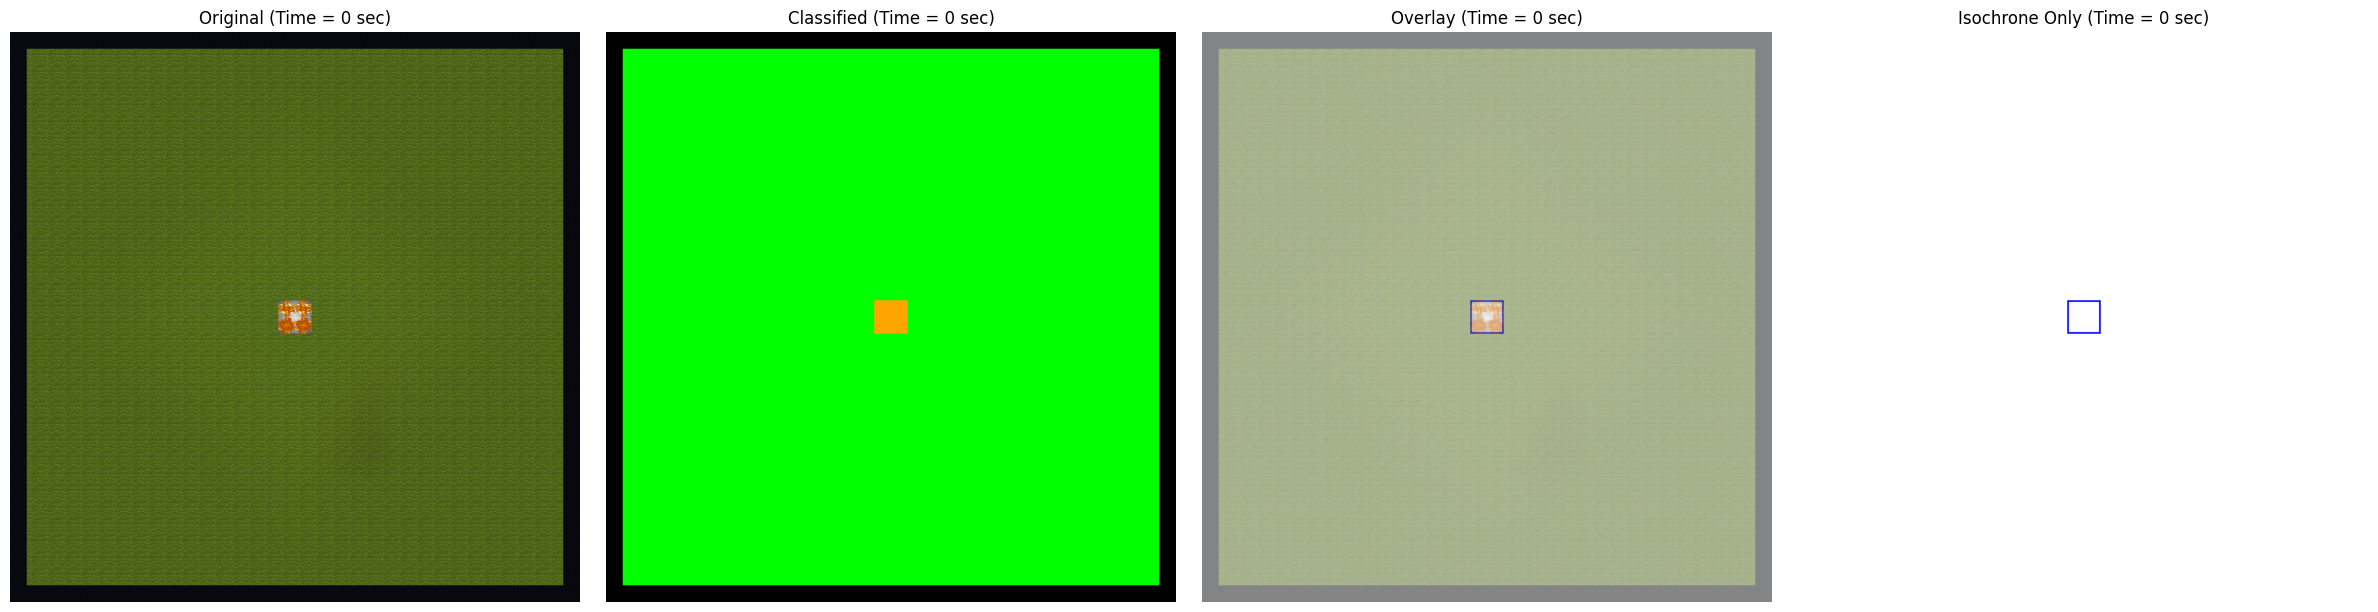

In [28]:
def get_isochrone_contours(labels_grid, upscale_factor=10):
    """
    Create a binary mask from the classification grid for cells labeled 'orange' or 'white',
    upscale it, and find contours.
    """
    grid_size_local = labels_grid.shape[0]
    mask = np.zeros((grid_size_local, grid_size_local), dtype=np.uint8)
    for r in range(grid_size_local):
        for c in range(grid_size_local):
            if labels_grid[r, c] in ('orange', 'white'):
                mask[r, c] = 255
    upscaled_size = (grid_size_local * upscale_factor, grid_size_local * upscale_factor)
    mask_upscaled = cv2.resize(mask, upscaled_size, interpolation=cv2.INTER_NEAREST)
    contours, _ = cv2.findContours(mask_upscaled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def draw_isochrone_only(labels_grid, upscale_factor=10):
    """
    Create a blank white canvas and draw the isochrone contour (from 'orange'/'white' cells)
    using thin red lines.
    """
    grid_size_local = labels_grid.shape[0]
    upscaled_size = (grid_size_local * upscale_factor, grid_size_local * upscale_factor)
    contours = get_isochrone_contours(labels_grid, upscale_factor=upscale_factor)
    outline_img = 255 * np.ones((upscaled_size[1], upscaled_size[0], 3), dtype=np.uint8)
    if contours:
        cv2.drawContours(outline_img, contours, -1, (255, 0, 0), 1)
    return outline_img

def show_four_panel_comparison(images_folder, grid_size=GRID_SIZE, upscale_factor=10,
                               image_step=DEFAULT_IMAGE_STEP, blend_alpha=0.5):
    """
    For each (or every nth) image in the folder, display a figure with 4 panels:
      1. Original image (RGB)
      2. Classified image (upscaled)
      3. Overlay image: the downscaled original with the isochrone overlaid
      4. Isochrone-only image (upscaled)
    
    The time label is computed as "Time = t sec", where t = index * image_step.
    """
    # Get image file paths (PNG first, then JPG) and subsample.
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
    if not image_paths:
        image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
    if not image_paths:
        raise ValueError("No images found in the specified folder.")
    image_paths = image_paths[::image_step]
    
    for idx, path in enumerate(image_paths):
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not load image {path}")
            continue
        
        # Panel 1: Original image (RGB)
        orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Panel 2: Classified image
        labels_grid, cls_img = process_image_into_grid(img, grid_size)
        upscaled_classified = cv2.resize(cls_img, (grid_size * upscale_factor, grid_size * upscale_factor),
                                         interpolation=cv2.INTER_NEAREST)
        
        # Panel 3: Overlay image (Original downscaled + isochrone overlaid)
        # Downscale the original to match the classified resolution.
        new_width = grid_size * upscale_factor
        new_height = grid_size * upscale_factor
        orig_downscaled = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
        # Compute isochrone from the labels_grid using your earlier function.
        iso_img = draw_isochrone_only(labels_grid, upscale_factor=upscale_factor)
        # Blend the downscaled original and the isochrone image.
        overlayed = cv2.addWeighted(orig_downscaled, blend_alpha, iso_img, 1 - blend_alpha, 0)
        
        # Panel 4: Isochrone-only image
        iso_only = iso_img
        
        # Compute time label (first image is time = 0 sec)
        time_label = idx * image_step
        
        # Create a 4-panel figure.
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        axes[0].imshow(orig_rgb)
        axes[0].set_title(f"Original (Time = {time_label} sec)")
        axes[0].axis('off')
        
        axes[1].imshow(upscaled_classified)
        axes[1].set_title(f"Classified (Time = {time_label} sec)")
        axes[1].axis('off')
        
        axes[2].imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
        axes[2].set_title(f"Overlay (Time = {time_label} sec)")
        axes[2].axis('off')
        
        axes[3].imshow(cv2.cvtColor(iso_only, cv2.COLOR_BGR2RGB))
        axes[3].set_title(f"Isochrone Only (Time = {time_label} sec)")
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage:
show_four_panel_comparison(images_folder, grid_size=GRID_SIZE, upscale_factor=10,
                        #    image_step=DEFAULT_IMAGE_STEP, 
                           image_step=100,
                           blend_alpha=0.5)


### Cell 6: Overlay of Isochrones (Color Gradient with Colorbar)

C:\Users\samih\AppData\Local\Temp\ipykernel_38712\3602214530.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', len(image_paths))


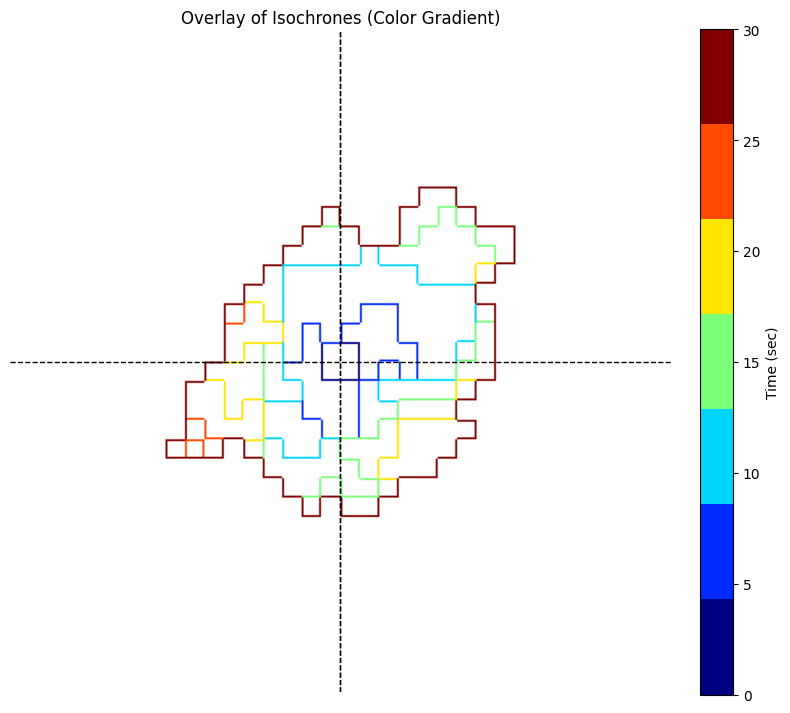

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [29]:
def overlay_all_isochrones_color_gradient(images_folder, grid_size=GRID_SIZE, upscale_factor=10, 
                                          line_thickness=1, image_step=DEFAULT_IMAGE_STEP,
                                          add_vertical=False, add_quadrant=False,
                                          show=True):
    """
    For all (or every nth) images in the folder, compute isochrone contours (from 'orange' or 'white' cells)
    and overlay them on a single white canvas using a color gradient.
    Optionally:
      - Draw center lines
      - Return the overlay image for further use (e.g. combining with heatmaps)
    
    Parameters:
      - show: If True, displays the image. Otherwise, returns it for programmatic use.
    Returns:
      - overlay_img: The RGB image with drawn contours
    """
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
    if not image_paths:
        image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
    if not image_paths:
        raise ValueError("No images found in the specified folder.")
    image_paths = image_paths[::image_step]
    
    cmap = cm.get_cmap('jet', len(image_paths))
    upscaled_size = (grid_size * upscale_factor, grid_size * upscale_factor)
    overlay_img = 255 * np.ones((upscaled_size[1], upscaled_size[0], 3), dtype=np.uint8)
    
    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not load image {path}")
            continue
        labels_grid, _ = process_image_into_grid(img, grid_size)
        contours = get_isochrone_contours(labels_grid, upscale_factor=upscale_factor)
        color_rgba = cmap(i)
        color_bgr = (int(color_rgba[2]*255), int(color_rgba[1]*255), int(color_rgba[0]*255))
        if contours:
            cv2.drawContours(overlay_img, contours, -1, color_bgr, line_thickness)

    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
        ax.set_title("Overlay of Isochrones (Color Gradient)")
        ax.axis('off')
        
        ncols = grid_size
        nrows = grid_size
        center_x = ncols // 2
        center_y = nrows // 2
        if add_vertical:
            plt.axvline(x=center_x * upscale_factor - 0.6, color="black", linestyle="--", linewidth=1)
        if add_quadrant:
            plt.axvline(x=center_x * upscale_factor - 0.6, color="black", linestyle="--", linewidth=1)
            plt.axhline(y=center_y * upscale_factor - 0.6, color="black", linestyle="--", linewidth=1)
        
        norm = plt.Normalize(vmin=0, vmax=(len(image_paths)-1)*image_step)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04,
                            ticks=np.linspace(0, (len(image_paths)-1)*image_step, num=len(image_paths)))
        cbar.set_label("Time (sec)")
        
        plt.tight_layout()
        plt.show()

    return overlay_img

# Example usage:
overlay_all_isochrones_color_gradient(images_folder, grid_size=GRID_SIZE, upscale_factor=10,
                                          line_thickness=1, 
                                        #   image_step=DEFAULT_IMAGE_STEP,
                                          image_step=DEFAULT_IMAGE_STEP*5,
                                          add_vertical=True, add_quadrant=True,
                                          show=True)


### Cell 7: Fire Spread Quantification and Plotting

In [30]:
# def graph_process_image_into_grid(img, grid_size=GRID_SIZE):
#     """
#     Splits the input image into a GRID_SIZE x GRID_SIZE grid.
#     Outer border cells are set to 'black'. Inner cells are classified
#     using the classify_cell_color() function.
#     Returns a (GRID_SIZE x GRID_SIZE) NumPy array of labels.
#     """
#     height, width, _ = img.shape
#     cell_h = height // grid_size
#     cell_w = width // grid_size
#     labels = []
#     for row in range(grid_size):
#         row_labels = []
#         for col in range(grid_size):
#             # Set outer border cells to 'black'
#             if row == 0 or row == grid_size - 1 or col == 0 or col == grid_size - 1:
#                 row_labels.append('black')
#             else:
#                 y_start = row * cell_h
#                 y_end = (row + 1) * cell_h
#                 x_start = col * cell_w
#                 x_end = (col + 1) * cell_w
#                 cell = img[y_start:y_end, x_start:x_end]
#                 avg_b = np.mean(cell[:, :, 0])
#                 avg_g = np.mean(cell[:, :, 1])
#                 avg_r = np.mean(cell[:, :, 2])
#                 row_labels.append(classify_cell_color((avg_b, avg_g, avg_r)))
#         labels.append(row_labels)
#     return np.array(labels)

# # Main code: Fire Spread Quantification and Plotting
# # Assumes a 1-second time step between images (TIME_STEP = 1)
# # Loads all images from images_folder, processes each one, and calculates the fire spread based on cell counts.
# image_paths = sorted(glob.glob(os.path.join(images_folder, '*.png')), key=os.path.getmtime)
# if not image_paths:
#     image_paths = sorted(glob.glob(os.path.join(images_folder, '*.jpg')), key=os.path.getmtime)
# if not image_paths:
#     raise ValueError("No images found in the specified folder.")

# # Optionally, add subsampling (if you want to process every nth image, set DEFAULT_IMAGE_STEP to n)
# image_paths = image_paths[::DEFAULT_IMAGE_STEP]

# fire_reached_area = []  # Count cells that are either 'orange' or 'white'
# fire_area = []          # Count cells that are 'orange'

# for path in image_paths:
#     img = cv2.imread(path)
#     if img is None:
#         print(f"Warning: Could not load image {path}")
#         continue
#     grid = graph_process_image_into_grid(img, grid_size=GRID_SIZE)
#     # Count cells that are either 'orange' or 'white'
#     reached_count = np.sum((grid == 'orange') | (grid == 'white'))
#     # Count cells that are only 'orange'
#     fire_count = np.sum(grid == 'orange')
#     fire_reached_area.append(reached_count)
#     fire_area.append(fire_count)

# # Generate time points (in seconds) based on the number of processed images.
# time_points = np.arange(len(fire_reached_area))  # since TIME_STEP is 1, time equals image index

# # Print the computed values
# print("Time (seconds):", time_points)
# print("Fire Reached Area (cells, orange+white):", fire_reached_area)
# print("Fire Area (cells, orange only):", fire_area)

# # Plot the total area over time
# plt.figure(figsize=(10,5))
# plt.plot(time_points, fire_reached_area, marker='o', label='Fire Reached Area (orange+white)')
# plt.plot(time_points, fire_area, marker='s', label='Fire Area (orange)')
# plt.xlabel("Time (seconds)")
# plt.ylabel("Number of Cells")
# plt.title("Fire Spread Area Over Time")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Compute the differences between consecutive images (area increase per second)
# fire_reached_diff = np.diff(fire_reached_area)
# fire_area_diff = np.diff(fire_area)

# # Print the computed differences (spread rates)
# print("New Fire Reached Area per second (cells):", fire_reached_diff)
# print("New Fire Area per second (cells):", fire_area_diff)

# # Plot the rate of spread over time
# plt.figure(figsize=(10,5))
# plt.plot(time_points[1:], fire_reached_diff, marker='o', label='New Fire Reached Area per Second')
# plt.plot(time_points[1:], fire_area_diff, marker='s', label='New Fire Area per Second')
# plt.xlabel("Time (seconds)")
# plt.ylabel("New Cells per Second")
# plt.title("Fire Spread Rate (Area Increase per Second)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### Cell 8: Arrival Time Heat Map - Helper Functions for Cell 9.3

In [31]:
def load_label_matrices(images_folder, grid_size=GRID_SIZE, image_step=DEFAULT_IMAGE_STEP):
    """
    Loads all (or every nth) image from the folder and computes the label matrix
    for each image using process_image_into_grid.
    
    Returns:
       A list of label matrices (each of shape (GRID_SIZE, GRID_SIZE)).
    """
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
    if not image_paths:
        image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
    if not image_paths:
        raise ValueError("No images found in the specified folder.")
    # Subsample image paths by image_step.
    image_paths = image_paths[::image_step]
    
    label_matrices = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not load image {path}")
            continue
        labels, _ = process_image_into_grid(img, grid_size)
        label_matrices.append(labels)
    return label_matrices

def compute_arrival_time_matrix(label_matrices, time_step=TIME_STEP):
    """
    From a list of label matrices (ordered in time), compute a matrix of arrival times.
    Each grid cell is assigned the time (in seconds) when it first becomes "orange" (fire).
    Cells that never become "orange" are set to NaN.
    """
    arrival_matrix = np.full((GRID_SIZE, GRID_SIZE), np.inf, dtype=float)
    
    # Loop through each time step (each matrix in the sequence)
    for t, labels in enumerate(label_matrices):
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                # If the cell is classified as "orange" and hasn't been ignited before,
                # assign its arrival time.
                if labels[i, j] == "orange" and np.isinf(arrival_matrix[i, j]):
                    arrival_matrix[i, j] = t * time_step
    arrival_matrix[np.isinf(arrival_matrix)] = np.nan
    return arrival_matrix

def plot_arrival_heatmap(arrival_matrix, cmap="hot", add_vertical=False, add_quadrant=False, remove_border=False):
    """
    Displays a heat map of the fire arrival times.  
    Optionally:
      - add_vertical: draw a vertical center line.
      - add_quadrant: draw both a vertical and a horizontal center line.
      - remove_border: remove the outer border (e.g. exclude the first and last rows and columns)
                      from the displayed image.
    """
    # Optionally remove the border.
    if remove_border:
        arr = arrival_matrix[1:-1, 1:-1]
        # For plotting, compute new center positions.
        nrows, ncols = arr.shape
        center_x = ncols // 2
        center_y = nrows // 2
    else:
        arr = arrival_matrix
        nrows, ncols = arr.shape
        center_x = ncols // 2
        center_y = nrows // 2

    plt.figure(figsize=(6,6))
    hm = plt.imshow(arr, cmap=cmap)
    plt.title("Fire Arrival Time Heat Map")
    plt.colorbar(hm, label="Arrival Time (sec)")
    
    # Optionally draw center lines.
    if add_vertical:
        plt.axvline(x=center_x - 0.6, color="black", linestyle="--", linewidth=1)  # vertical center
    if add_quadrant:
        plt.axvline(x=center_x - 0.6, color="black", linestyle="--", linewidth=1)
        plt.axhline(y=center_y - 0.6, color="black", linestyle="--", linewidth=1)
    
    plt.tight_layout()
    plt.show()

label_matrices = load_label_matrices(images_folder, grid_size=GRID_SIZE, image_step=DEFAULT_IMAGE_STEP)
arrival_matrix = compute_arrival_time_matrix(label_matrices, time_step=TIME_STEP)
# Example: plot heat map with quadrant center lines and without border

# FOR CELL 9.3
# plot_arrival_heatmap(arrival_matrix, cmap="hot", add_quadrant=True, add_vertical=False, remove_border=True)


### Cell 9.1: Arrival Time Heat Map with "Smooth" Isochrone Plots using LEVELS

In [32]:
# def plot_arrival_heatmap_with_isochrones(arrival_matrix, cmap="hot", add_vertical=False, add_quadrant=False, remove_border=False, levels=10):
#     """
#     Plots the arrival time heat map and overlays isochrone contours.

#     Parameters:
#       - levels: number of contour levels (or a list of levels) to draw.
#       - add_vertical: draw vertical center line.
#       - add_quadrant: draw both vertical and horizontal center lines.
#       - remove_border: exclude the outer border cells from the heat map.
#     """
#     # Optionally remove the border.
#     if remove_border:
#         data = arrival_matrix[1:-1, 1:-1]
#         center_offset = 1  # we removed one row/column from each side
#     else:
#         data = arrival_matrix
#         center_offset = 0  # no shift

#     nrows, ncols = data.shape
#     center_x = ncols // 2
#     center_y = nrows // 2

#     plt.figure(figsize=(6,6))
#     hm = plt.imshow(data, cmap=cmap)
#     plt.title("Arrival Time Heat Map with Isochrones")
#     plt.colorbar(hm, label="Arrival Time (sec)")

#     # Create contour lines over the filled data (handling NaNs)
#     data_for_contour = np.nan_to_num(data, nan=np.nanmax(data) + 1)
#     contours = plt.contour(data_for_contour, levels=levels, colors="blue", linewidths=1)
#     plt.clabel(contours, inline=True, fontsize=8)

#     if add_vertical:
#         plt.axvline(x=center_x - 0.6, color="black", linestyle="--", linewidth=1)
#     if add_quadrant:
#         plt.axvline(x=center_x - 0.6, color="black", linestyle="--", linewidth=1)
#         plt.axhline(y=center_y - 0.6, color="black", linestyle="--", linewidth=1)

#     plt.tight_layout()
#     plt.show()

# plot_arrival_heatmap_with_isochrones(arrival_matrix, 
#                                      cmap="hot", 
#                                      add_quadrant=True, 
#                                      remove_border=True, 
#                                      levels=5)


### Cell 9.2: Arrival Time Heat Map with "Smooth" Isochrone Plots using TIME STEPPED ISOCHRONES

In [33]:
# # === Cell 9 (return to original style, but interval-based) ===================
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_arrival_heatmap_with_isochrones(arrival_matrix,
#                                          cmap="hot",
#                                          time_interval=10,   # NEW: spacing in sec
#                                          add_vertical=False,
#                                          add_quadrant=False,
#                                          remove_border=False):
#     """
#     Draw arrival-time heat map plus isochrones every <time_interval> seconds.
#     This keeps the original behaviour: NaNs are filled with a large sentinel
#     so contours wrap around the burning area, giving full “edge” isochrones.
#     """

#     # --- 1) Trim border if requested -----------------------------------------
#     if remove_border:
#         data = arrival_matrix[1:-1, 1:-1]
#     else:
#         data = arrival_matrix

#     # --- 2) Build contour level list -----------------------------------------
#     t_min = np.nanmin(data)
#     t_max = np.nanmax(data)

#     # first level = next multiple of interval above t_min
#     first_level = (np.floor(t_min / time_interval) + 1) * time_interval
#     levels = np.arange(first_level, t_max + time_interval, time_interval)

#     # --- 3) Prepare data for contour (original trick) ------------------------
#     sentinel = t_max + time_interval            # larger than any real value
#     data_for_contour = np.nan_to_num(data, nan=sentinel)

#     # --- 4) Plot --------------------------------------------------------------
#     nrows, ncols = data.shape
#     cx, cy = ncols // 2, nrows // 2             # centres for guide lines

#     plt.figure(figsize=(6, 6))

#     hm = plt.imshow(data, cmap=cmap)
#     plt.colorbar(hm, label="Arrival Time (sec)")

#     ctr = plt.contour(data_for_contour,
#                       levels=levels,
#                       colors="blue",
#                       linewidths=1)
#     plt.clabel(ctr, fmt=lambda v: f"{int(v)} s", inline=True, fontsize=8)

#     # optional guide lines
#     if add_vertical or add_quadrant:
#         plt.axvline(cx - 0.6, color="black", linestyle="--", linewidth=1)
#     if add_quadrant:
#         plt.axhline(cy - 0.6, color="black", linestyle="--", linewidth=1)

#     plt.title(f"Arrival Time Heat Map with {time_interval}s Isochrones")
#     plt.tight_layout()
#     plt.show()


# # Example usage:
# plot_arrival_heatmap_with_isochrones(arrival_matrix,
#                                      cmap="hot",
#                                      time_interval=50,   # NEW: spacing in sec
#                                      add_quadrant=True,
#                                      remove_border=True)

### Cell 9.3: Arrival Time Heat Map with "Smooth" Isochrone Plots using TIME STEPPED ISOCHRONES and ORIGINAL Background Colours (NOT WHITE)

C:\Users\samih\AppData\Local\Temp\ipykernel_38712\2525578484.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgb_img = (cm.get_cmap(cmap)(norm)[:, :, :3] * 255).astype(np.uint8)   # RGB
C:\Users\samih\AppData\Local\Temp\ipykernel_38712\2525578484.py:97: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Arrival Time (sec)")


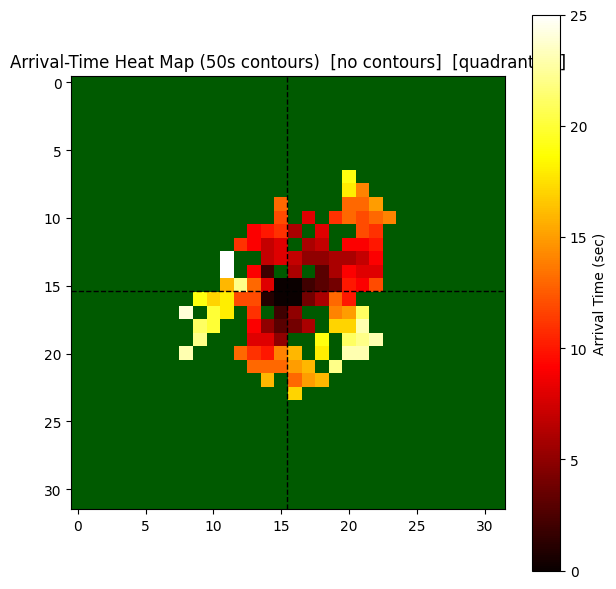

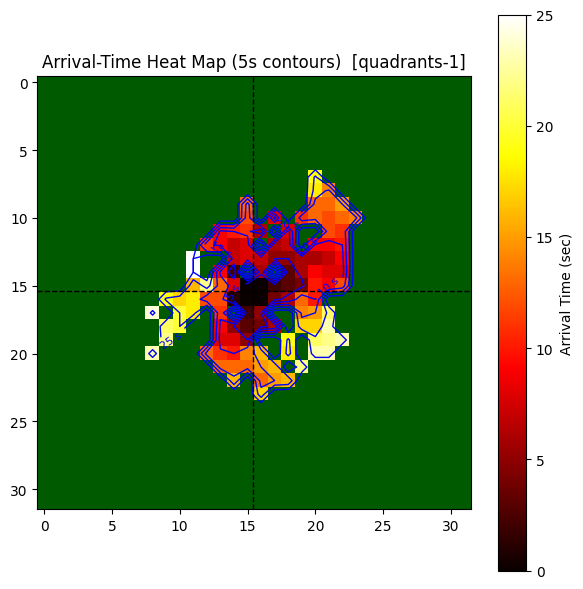

In [40]:
# === Cell 9 (interval-based, with background + contour switches) ============
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# RGB constants (Matplotlib order)
PURPLE     = (178,  69, 208)
GREEN      = (  0, 255,   0)
PINK       = (255, 192, 203)
LIGHTBLUE  = (173, 216, 230)
DARKGREEN  = (  0,  90,   0)
WHITE      = (255, 255, 255)

def _quad_rgb(y, x, nrows, ncols, mode):
    """Return RGB tuple for pixel (y,x) according to requested quadrant mode."""
    top    = y < nrows // 2
    left   = x < ncols // 2

    if mode == "quadrants-4":          # TL / TR / BL / BR
        if  top and  left:  return PURPLE
        if  top and not left: return GREEN
        if not top and  left:  return PINK
        return LIGHTBLUE

    if mode == "quadrants-3":          # TL purple | TR green | bottom light-blue
        if  left:  return PURPLE
        if  top and not left: return GREEN
        return LIGHTBLUE

    if mode == "quadrants-2":          # left purple | right green
        return PURPLE if left else GREEN

    if mode == "quadrants-1":          # whole board dark green
        return DARKGREEN

    # default fallback (shouldn't reach here)
    return WHITE


def plot_arrival_heatmap_with_isochrones(arrival_matrix,
                                         cmap="hot",
                                         time_interval=10,
                                         add_vertical=False,
                                         add_quadrant=False,
                                         remove_border=False,
                                         *,
                                         unburnt_style="white",
                                         show_isochrones=True):
    """
    Heat-map of arrival times with optional isochrone contours and custom
    colouring of *never-burnt* cells (NaNs).

    Parameters
    ----------
    unburnt_style : str
        "white" | "quadrants-4" | "quadrants-3" | "quadrants-2" | "quadrants-1"
    show_isochrones : bool
        Draw the blue contour lines if True (default); skip them if False.
    """

    # ---------------------------------------------------------------- data prep
    data = arrival_matrix[1:-1, 1:-1] if remove_border else arrival_matrix
    nrows, ncols = data.shape
    cx, cy = ncols // 2, nrows // 2           # for guide lines

    finite_mask = np.isfinite(data)
    t_min, t_max = np.nanmin(data), np.nanmax(data)

    # normalised colormap for finite arrival times
    norm = (data - t_min) / (t_max - t_min)
    rgb_img = (cm.get_cmap(cmap)(norm)[:, :, :3] * 255).astype(np.uint8)   # RGB

    # -------------------------------------------------- paint the NaN cells
    ys, xs = np.where(~finite_mask)
    for y, x in zip(ys, xs):
        if unburnt_style == "white":
            rgb_img[y, x] = WHITE
        else:
            rgb_img[y, x] = _quad_rgb(y, x, nrows, ncols, unburnt_style)

    # -------------------------------------------------- sentinel for contours
    sentinel = t_max + time_interval
    data_for_contour = np.nan_to_num(data, nan=sentinel)

    # contour levels
    first_lvl = (np.floor(t_min / time_interval) + 1) * time_interval
    levels = np.arange(first_lvl, t_max + time_interval, time_interval)

    # ---------------------------------------------------------------- plotting
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_img, interpolation="nearest")          # keep blocky look

    # colour-bar (still linked to numerical values)
    sm = plt.cm.ScalarMappable(cmap=cmap,
                               norm=plt.Normalize(vmin=t_min, vmax=t_max))
    sm.set_array([])
    plt.colorbar(sm, label="Arrival Time (sec)")

    if show_isochrones:
        ctr = plt.contour(data_for_contour,
                          levels=levels,
                          colors="blue",
                          linewidths=1)
        plt.clabel(ctr, fmt=lambda v: f"{int(v)} s", inline=True, fontsize=8)

    # guide lines
    if add_vertical or add_quadrant:
        plt.axvline(cx - 0.6, color="black", linestyle="--", linewidth=1)
    if add_quadrant:
        plt.axhline(cy - 0.6, color="black", linestyle="--", linewidth=1)

    plt.title(f"Arrival-Time Heat Map ({time_interval}s contours)"
              f"{'' if show_isochrones else '  [no contours]'}"
              f"  [{unburnt_style}]")
    plt.tight_layout()
    plt.show()


# # 1️⃣  Classic look, contours on
# plot_arrival_heatmap_with_isochrones(arrival_matrix,
#                                      time_interval=50,
#                                      add_quadrant=True,
#                                      remove_border=True,
#                                      unburnt_style="white"
#                                      )

# 2️⃣  Quadrant-4 background, contours on
plot_arrival_heatmap_with_isochrones(arrival_matrix,
                                     time_interval=50,
                                     add_quadrant=True,
                                     remove_border=True,
                                     unburnt_style="quadrants-1",
                                     show_isochrones=False)

# 3️⃣  Vertical split background, NO contours
plot_arrival_heatmap_with_isochrones(arrival_matrix,
                                     time_interval=5,
                                     add_quadrant=True,
                                     remove_border=True,
                                     unburnt_style="quadrants-1",
                                     show_isochrones=True)


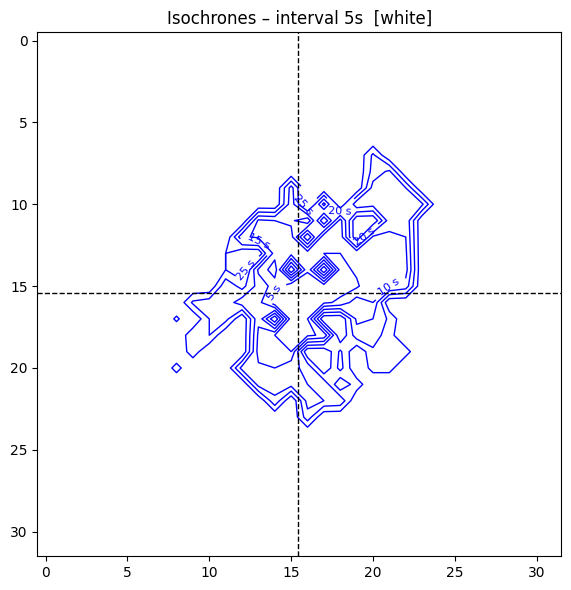

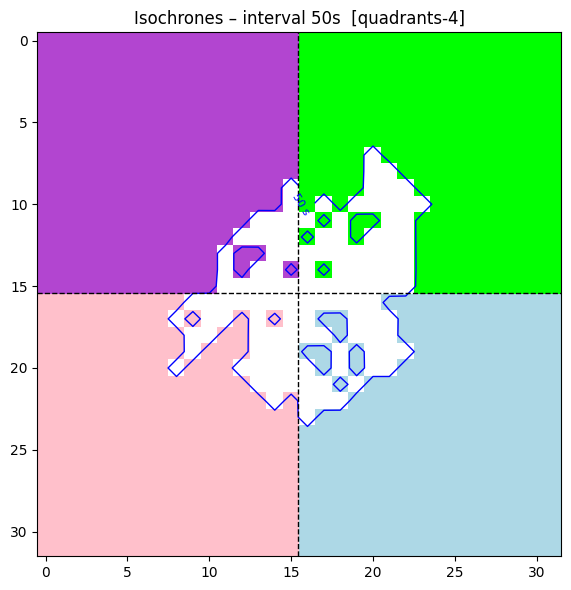

C:\Users\samih\AppData\Local\Temp\ipykernel_38712\1519222194.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heat_rgb = (cm.get_cmap(cmap)(norm)[:, :, :3] * 255).astype(np.uint8)
C:\Users\samih\AppData\Local\Temp\ipykernel_38712\1519222194.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Arrival Time (sec)")


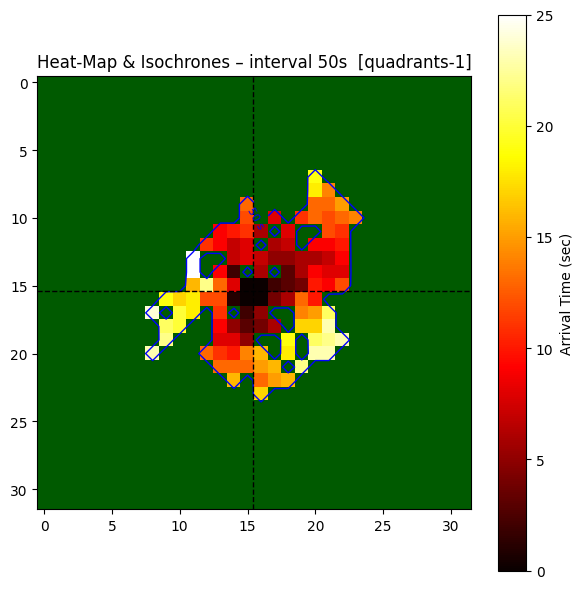

In [42]:
# === Cell 9 (heat-map & contour visibility switches) ========================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# RGB constants (Matplotlib order)
PURPLE     = (178,  69, 208)
GREEN      = (  0, 255,   0)
PINK       = (255, 192, 203)
LIGHTBLUE  = (173, 216, 230)
DARKGREEN  = (  0,  90,   0)
WHITE      = (255, 255, 255)

def _quad_rgb(y, x, nrows, ncols, mode):
    """Return RGB tuple for pixel (y,x) according to requested quadrant mode."""
    top   = y < nrows // 2
    left  = x < ncols // 2

    if mode == "quadrants-4":
        if  top and  left:  return PURPLE
        if  top and not left: return GREEN
        if not top and  left:  return PINK
        return LIGHTBLUE

    if mode == "quadrants-3":
        if  left:  return PURPLE
        if  top and not left: return GREEN
        return LIGHTBLUE

    if mode == "quadrants-2":
        return PURPLE if left else GREEN

    if mode == "quadrants-1":
        return DARKGREEN

    return WHITE            # fallback


def plot_arrival_heatmap_with_isochrones(arrival_matrix,
                                         cmap="hot",
                                         time_interval=10,
                                         add_vertical=False,
                                         add_quadrant=False,
                                         remove_border=False,
                                         *,
                                         unburnt_style="white",
                                         show_heatmap=True,
                                         show_isochrones=True):
    """
    Arrival-time visualiser with independent switches for heat-map and contour layer.

    unburnt_style   : "white" | "quadrants-4" | "quadrants-3" | "quadrants-2" | "quadrants-1"
    show_heatmap    : bool  – display coloured heat map of arrival times
    show_isochrones : bool  – draw blue contour lines
    """

    # ---------------------------- data slice / geometry ----------------------
    data = arrival_matrix[1:-1, 1:-1] if remove_border else arrival_matrix
    nrows, ncols = data.shape
    cx, cy = ncols // 2, nrows // 2

    finite_mask = np.isfinite(data)
    t_min, t_max = np.nanmin(data), np.nanmax(data)

    # ---------------------------- background canvas --------------------------
    rgb_img = np.full((nrows, ncols, 3), WHITE, dtype=np.uint8)  # start white

    # fill finite cells with heat-map colours, if requested
    if show_heatmap:
        norm = (data - t_min) / (t_max - t_min)
        heat_rgb = (cm.get_cmap(cmap)(norm)[:, :, :3] * 255).astype(np.uint8)
        rgb_img[finite_mask] = heat_rgb[finite_mask]

    # paint the NaN (never-burnt) cells according to unburnt_style
    ys, xs = np.where(~finite_mask)
    for y, x in zip(ys, xs):
        if unburnt_style != "white":
            rgb_img[y, x] = _quad_rgb(y, x, nrows, ncols, unburnt_style)

    # ---------------------------- contour prep -------------------------------
    sentinel = t_max + time_interval
    data_for_contour = np.nan_to_num(data, nan=sentinel)
    first_lvl = (np.floor(t_min / time_interval) + 1) * time_interval
    levels = np.arange(first_lvl, t_max + time_interval, time_interval)

    # ---------------------------- plotting -----------------------------------
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_img, interpolation="nearest")

    # colour-bar only if heat-map is visible
    if show_heatmap:
        sm = plt.cm.ScalarMappable(cmap=cmap,
                                   norm=plt.Normalize(vmin=t_min, vmax=t_max))
        sm.set_array([])
        plt.colorbar(sm, label="Arrival Time (sec)")

    # iso-contours
    if show_isochrones:
        ctr = plt.contour(data_for_contour,
                          levels=levels,
                          colors="blue",
                          linewidths=1)
        plt.clabel(ctr, fmt=lambda v: f"{int(v)} s", inline=True, fontsize=8)

    # centre guide lines
    if add_vertical or add_quadrant:
        plt.axvline(cx - 0.6, color="black", linestyle="--", linewidth=1)
    if add_quadrant:
        plt.axhline(cy - 0.6, color="black", linestyle="--", linewidth=1)

    # ---------------------------- title --------------------------------------
    title_bits = []
    if show_heatmap:
        title_bits.append("heat-map")
    if show_isochrones:
        title_bits.append("isochrones")
    if not title_bits:
        title_bits.append("blank")

    plt.title(f"{' & '.join(title_bits).title()} – interval {time_interval}s  "
              f"[{unburnt_style}]")
    plt.tight_layout()
    plt.show()


    # ① Only contours on white background
plot_arrival_heatmap_with_isochrones(arrival_matrix,
                                     time_interval=5,
                                     add_quadrant=True,
                                     remove_border=True,
                                     unburnt_style="white",
                                     show_heatmap=False,
                                     show_isochrones=True)

# ② Quadrant-4 background + contours, no heat-map colours
plot_arrival_heatmap_with_isochrones(arrival_matrix,
                                     time_interval=50,
                                     add_quadrant=True,
                                     remove_border=True,
                                     unburnt_style="quadrants-4",
                                     show_heatmap=False,
                                     show_isochrones=True)

# ③ Full visual (heat-map + contours) with dark-green board
plot_arrival_heatmap_with_isochrones(arrival_matrix,
                                     time_interval=50,
                                     add_quadrant=True,
                                     remove_border=True,
                                     unburnt_style="quadrants-1",
                                     show_heatmap=True,
                                     show_isochrones=True)



### Cell 10: Calculation of RoS

In [35]:
# def compute_local_RoS(arrival_matrix, delta=1):
#     """
#     Computes an approximate local rate of spread (RoS) for a selected cell using finite differences.
#     The formula is: R = 1 / |∇T|, where ∇T is approximated by central differences.
    
#     Parameters:
#       - arrival_matrix: 2D array of arrival times (in sec) for each grid cell.
#       - delta: grid spacing in metres.
      
#     Returns:
#       A tuple (dT_dx, dT_dy, gradient_magnitude, local_RoS) for a selected internal cell.
#     """
#     # Choose a cell away from the border (e.g., cell at (i, j) = (GRID_SIZE//2, GRID_SIZE//2))
#     i = GRID_SIZE // 2
#     j = GRID_SIZE // 2
#     if i <= 0 or i >= GRID_SIZE-1 or j <= 0 or j >= GRID_SIZE-1:
#         print("Selected cell is on the border.")
#         return None
    
#     T_right = arrival_matrix[i+1, j]
#     T_left  = arrival_matrix[i-1, j]
#     T_down  = arrival_matrix[i, j+1]
#     T_up    = arrival_matrix[i, j-1]
    
#     # Compute central differences (if any neighbor is NaN, skip)
#     if np.isnan(T_right) or np.isnan(T_left) or np.isnan(T_down) or np.isnan(T_up):
#         print("Cannot compute gradient for the selected cell due to missing data.")
#         return None
    
#     dT_dx = (T_right - T_left) / (2 * delta)
#     dT_dy = (T_down - T_up) / (2 * delta)
#     gradient_magnitude = np.sqrt(dT_dx**2 + dT_dy**2)
#     local_RoS = 1 / gradient_magnitude if gradient_magnitude > 0 else np.nan
    
#     # Print internal computation details.
#     print(f"For cell ({i},{j}):")
#     print(f"  dT/dx = {dT_dx:.4f} sec/m, dT/dy = {dT_dy:.4f} sec/m")
#     print(f"  |∇T| = {gradient_magnitude:.4f} sec/m")
#     print(f"  Estimated local Rate-of-Spread = {local_RoS:.4f} m/sec")
    
#     return (dT_dx, dT_dy, gradient_magnitude, local_RoS)

# # Combined Cell: Compute Arrival Matrix, Calculate Local RoS, and Plot Combined Heat Map Overlay
# label_matrices = load_label_matrices(images_folder, grid_size=GRID_SIZE, image_step=DEFAULT_IMAGE_STEP)
# arrival_matrix = compute_arrival_time_matrix(label_matrices, time_step=TIME_STEP)

# # Compute local rate-of-spread for a selected cell using finite differences.
# _ = compute_local_RoS(arrival_matrix, delta=1)

# # Now, plot the heat map with isochrone overlays and center lines (optionally)
# # plot_arrival_heatmap_with_isochrones(arrival_matrix, cmap="hot", add_quadrant=True, remove_border=True, levels=10)


#### Cell 11: Combined Plot – Heat Map with Isochrone Overlay

C:\Users\samih\AppData\Local\Temp\ipykernel_38712\3602214530.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', len(image_paths))


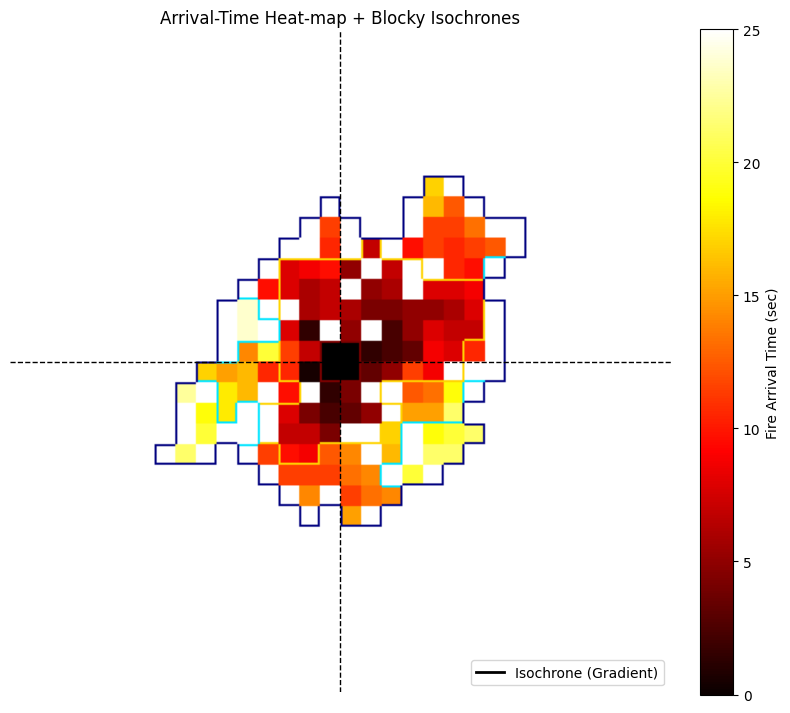

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [36]:
def create_heatmap_image(arrival_matrix, cmap_name="hot"):
    """
    Creates an RGB heat map image from the arrival_matrix.
    NaN values are replaced by a value slightly higher than the max.
    """
    arr = np.copy(arrival_matrix)
    max_val = np.nanmax(arr)
    arr[np.isnan(arr)] = max_val + 1
    norm_arr = (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))
    norm_arr = (norm_arr * 255).astype(np.uint8)
    heat_img = cv2.applyColorMap(norm_arr, cv2.COLORMAP_HOT)
    heat_img = cv2.cvtColor(heat_img, cv2.COLOR_BGR2RGB)
    return heat_img

def plot_combined_heatmap_and_isochrones(
    images_folder,
    grid_size=GRID_SIZE,
    upscale_factor=10,
    heatmap_step=DEFAULT_IMAGE_STEP,
    iso_step=DEFAULT_IMAGE_STEP * 5,
    cmap_name="hot",
    remove_border=True,
    add_vertical=False,
    add_quadrant=False,
    iso_line_thick=1,
    isochrones_colored=True  # NEW: Toggle colored vs red contours
):
    """
    Combined visualisation of fire spread:
    ▸ Heat map of arrival times (based on `heatmap_step`)
    ▸ Blocky isochrone contours (based on `iso_step`)
    Includes colorbar and legend.

    Parameters:
        isochrones_colored: If True, use gradient color contours;
                            If False, use red for all isochrones.
    """
    # --- Step 1: Compute arrival matrix ---
    label_mats = load_label_matrices(images_folder, grid_size=grid_size, image_step=heatmap_step)
    arr_matrix = compute_arrival_time_matrix(label_mats, time_step=TIME_STEP)

    if remove_border:
        arr_matrix = arr_matrix[1:-1, 1:-1]
        grid_size_used = grid_size - 2
    else:
        grid_size_used = grid_size

    # --- Step 2: Create heatmap background ---
    arr_for_colorbar = np.copy(arr_matrix)
    heat_img = create_heatmap_image(arr_matrix, cmap_name=cmap_name)
    target_size = grid_size_used * upscale_factor
    heat_img = cv2.resize(heat_img, (target_size, target_size), interpolation=cv2.INTER_NEAREST)

    # --- Step 3: Isochrone overlay ---
    # If single-color, we'll override the color inside the overlay function
    original_overlay_function = overlay_all_isochrones_color_gradient

    def overlay_with_fixed_color(*args, **kwargs):
        overlay_img = 255 * np.ones((grid_size * upscale_factor, grid_size * upscale_factor, 3), dtype=np.uint8)
        image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
        if not image_paths:
            image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
        image_paths = image_paths[::iso_step]
        for path in image_paths:
            img = cv2.imread(path)
            if img is None:
                continue
            labels_grid, _ = process_image_into_grid(img, grid_size)
            contours = get_isochrone_contours(labels_grid, upscale_factor=upscale_factor)
            color_bgr = (255, 0, 0)  # CHOOSE THE ISOCHRONE COLOR HERE (e.g., red)
            if contours:
                cv2.drawContours(overlay_img, contours, -1, color_bgr, iso_line_thick)
        if remove_border:
            pad = upscale_factor
            overlay_img = overlay_img[pad:-pad, pad:-pad, :]
        return overlay_img

    overlay_img = (
        original_overlay_function(
            images_folder,
            grid_size=grid_size,
            upscale_factor=upscale_factor,
            line_thickness=iso_line_thick,
            image_step=iso_step,
            add_vertical=False,
            add_quadrant=False,
            show=False
        )
        if isochrones_colored else
        overlay_with_fixed_color()
    )
    if remove_border and isochrones_colored:
        pad = upscale_factor
        overlay_img = overlay_img[pad:-pad, pad:-pad, :]

    overlay_img = cv2.resize(overlay_img, (target_size, target_size), interpolation=cv2.INTER_NEAREST)

    # --- Step 4: Composite ---
    mask = np.any(overlay_img != 255, axis=2)
    mask3 = np.repeat(mask[:, :, None], 3, axis=2)
    composite = heat_img.copy()
    composite[mask3] = overlay_img[mask3]

    # --- Step 5: Plot ---
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(composite)
    ax.set_title("Arrival-Time Heat-map + Blocky Isochrones")
    ax.axis("off")

    # Center lines
    cx = target_size // 2
    cy = target_size // 2
    if add_vertical or add_quadrant:
        ax.axvline(x=cx - 0.6, color="black", linestyle="--", linewidth=1)
    if add_quadrant:
        ax.axhline(y=cy - 0.6, color="black", linestyle="--", linewidth=1)

    # --- Step 6: Colorbar ---
    norm = plt.Normalize(vmin=np.nanmin(arr_for_colorbar), vmax=np.nanmax(arr_for_colorbar))
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap_name), norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Fire Arrival Time (sec)")

    # --- Step 7: Legend for isochrone lines ---
    from matplotlib.lines import Line2D
    legend_color = 'red' if not isochrones_colored else 'black'
    legend_label = 'Isochrone (Contours)' if not isochrones_colored else 'Isochrone (Gradient)'
    legend_elements = [Line2D([0], [0], color=legend_color, lw=2, label=legend_label)]
    ax.legend(handles=legend_elements, loc='lower right', frameon=True)

    plt.tight_layout()
    plt.show()

    return composite


plot_combined_heatmap_and_isochrones(
    images_folder,
    heatmap_step=1,
    iso_step=10,
    remove_border=True,
    add_vertical=True,
    add_quadrant=True,
    # isochrones_colored=False    # 🔴 All red contours
    isochrones_colored=True     # 🌈 Use gradient color for contours
)